# Will They Seek Treatment for a Mental Illness?

__By Lotus Baumgarner__

This is part two of two notebooks. This notebook covers the Models, Hyperparameter Tuning, Final Model Selection and Conclusion/Next Steps. The part one notebook covers the Data/Problem understanding, Data Cleaning, Visualizations and Initial Feature Selection.


In [1]:
# Basic Data Manipulation
import pandas as pd
import numpy as np

# Visualization and Statistics
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats as stats

# Preprocessing and Models
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from xgboost import XGBClassifier

# Other Imports
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import os  
import pickle

In [2]:
df = pd.read_csv("C:\\Users\\lotus\\Documents\\Flatiron\\Projects\\Phase5-CapstoneProject\\Data\\Treatment2_data.csv")

df.head()

,Gender,Occupation,Self_Employed,Family_History,Treatment,Days_Indoors,Growing_Stress,Changes_Habits,Mental_Health_History,Mood_Swings,Coping_Struggles,Work_Interest,Social_Weakness,Mental_Health_Interview,Care_Options
0,Male,Housewife,No,No,No,15-30 days,No,No,No,High,Yes,Yes,No,No,No
1,Female,Housewife,No,No,No,15-30 days,Maybe,No,Maybe,Medium,Yes,No,Yes,No,Not sure
2,Female,Housewife,No,Yes,Yes,31-60 days,Yes,No,Maybe,Medium,No,Yes,No,No,No
3,Male,Others,No,No,No,1-14 days,Yes,Yes,No,Low,Yes,No,Yes,No,Yes
4,Female,Housewife,No,No,No,Go out Every day,Maybe,Yes,No,Low,Yes,Maybe,No,No,Not sure


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 15 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   Gender                   100000 non-null  object
 1   Occupation               100000 non-null  object
 2   Self_Employed            100000 non-null  object
 3   Family_History           100000 non-null  object
 4   Treatment                100000 non-null  object
 5   Days_Indoors             100000 non-null  object
 6   Growing_Stress           100000 non-null  object
 7   Changes_Habits           100000 non-null  object
 8   Mental_Health_History    100000 non-null  object
 9   Mood_Swings              100000 non-null  object
 10  Coping_Struggles         100000 non-null  object
 11  Work_Interest            100000 non-null  object
 12  Social_Weakness          100000 non-null  object
 13  Mental_Health_Interview  100000 non-null  object
 14  Care_Options         

## 3. Train-Test Split & Basic Pipeline Set-up:
Since all my columns are categorical and not ordered, I'll be using __One Hot Encoder__ to convert my data into numerical format. 

I used __Train-Test Split__ with a holdout set and __Cross-Validation__. I used a 80/20 split for my training_validation set and holdout set. Then I used a 75/25 split to split the train_validation set into seperate training and validation sets. I also mapped my target variable (y) to be Yes = 1 and No = 0.

__I am labeling my TP, TN, FP, and FN as follows:__

•	__True Positives (TP):__ The number of individuals who were correctly predicted to seek treatment for a mental illness (i.e., the model predicted "Yes" for treatment, and the actual value was also "Yes").

•	__True Negatives (TN):__ The number of individuals who were correctly predicted not to seek treatment for a mental illness (i.e., the model predicted "No" for treatment, and the actual value was also "No").

•	__False Positives (FP):__ The number of individuals who were incorrectly predicted to seek treatment for a mental illness (i.e., the model predicted "Yes" for treatment, but the actual value was "No").

•	__False Negatives (FN):__ The number of individuals who were incorrectly predicted not to seek treatment for a mental illness (i.e., the model predicted "No" for treatment, but the actual value was "Yes").

Since my dataset is balanced 50/50 now, I will be focusing on __Accuracy__ as my metric.

In [4]:
# Selected only the features with significant association. (See EDAs-Feature Selection Notebook)
significant_features = ['Gender', 'Family_History', 'Mental_Health_Interview', 'Care_Options', 
                        'Self_Employed', 'Coping_Struggles', 'Growing_Stress']

# Defined X and y to be split. And mapped y to numeric format.
X = df[significant_features]
y = df['Treatment'].map({'Yes': 1, 'No': 0})

# First split the dataset into train_validation and holdout sets (80/20)
X_train_val, X_holdout, y_train_val, y_holdout = train_test_split(X, y, test_size=0.2, random_state=42)

# Then split the train_validation set into seperate training and validation sets (75/25)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)


In [5]:
# Printed shape of all training, validation, and holdout sets.
print("The X Train_Validation set shape is ", X_train_val.shape)
print("The X Train set shape is            ", X_train.shape)
print("The X Validation set shape is       ", X_val.shape)
print("The X Holdout set shape is          ", X_holdout.shape)
print()
print("The y Train_Validation set shape is ", y_train_val.shape)
print("The y Train set shape is            ", y_train.shape)
print("The y Validation set shape is       ", y_val.shape)
print("The y Holdout set shape is          ", y_holdout.shape)

The X Train_Validation set shape is  (80000, 7)
The X Train set shape is             (60000, 7)
The X Validation set shape is        (20000, 7)
The X Holdout set shape is           (20000, 7)

The y Train_Validation set shape is  (80000,)
The y Train set shape is             (60000,)
The y Validation set shape is        (20000,)
The y Holdout set shape is           (20000,)


In [6]:
# Created a preprocessing pipeline with OneHotEncoder for categorical features
categorical_features = significant_features

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features)
    ])

# Defined a basic pipeline with an empty Model place
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', 'Model')
])

pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Gender', 'Family_History',
                                                   'Mental_Health_Interview',
                                                   'Care_Options',
                                                   'Self_Employed',
                                                   'Coping_Struggles',
                                                   'Growing_Stress'])])),
                ('model', 'Model')])

## 4A. Model 1: Baseline - Logistic Regression:

In [7]:
# Created the Baseline model using Logistic Regression
LogReg = LogisticRegression(max_iter=1000, random_state=42)

# Added LogReg to empty model slot on pipeline
logreg_pipeline = pipeline.set_params(model=LogReg)

logreg_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Gender', 'Family_History',
                                                   'Mental_Health_Interview',
                                                   'Care_Options',
                                                   'Self_Employed',
                                                   'Coping_Struggles',
                                                   'Growing_Stress'])])),
                ('model', LogisticRegression(max_iter=1000, random_state=42))])

In [8]:
# Trained the model
logreg_pipeline.fit(X_train, y_train)

# Predictions & Evaluation
y_pred1 = logreg_pipeline.predict(X_val)
accuracy1 = accuracy_score(y_val, y_pred1)
classification_report1 = classification_report(y_val, y_pred1)

# Cross-validated
cv_scores1 = cross_val_score(logreg_pipeline, X_train_val, y_train_val, cv=10, scoring='accuracy')

print("\033[1mThe Accuracy score on the validation set is:\033[0m ", accuracy1)
print("\033[1mClassification Report:\033[0m\n", classification_report1)
print("\033[1mCross-validation accuracy scores:\033[0m\n", cv_scores1)

The Accuracy score on the validation set is:  0.70765
Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.65      0.69      9984
           1       0.69      0.77      0.72     10016

    accuracy                           0.71     20000
   macro avg       0.71      0.71      0.71     20000
weighted avg       0.71      0.71      0.71     20000

Cross-validation accuracy scores:
 [0.704625 0.71075  0.705375 0.706125 0.716125 0.703    0.7055   0.71125
 0.714375 0.704125]


##### FINDINGS:  Validation Set
Keeping in mind that Yes = 1 and No = 0.  
The __Accuracy Score__ of __71%__(70.77%) means that out of every 100 samples, the model correctly predicted 71 of them.  

The __Precision__ score indicates that the model correctly predicted when a person would not seek treatment 73% of the time and correctly predicted when a person would seek treatment 69% of the time.

The __Recall__ score indicates that the model correctly caught all the cases it needed to 65% of the time for those unlikely to seek treatment and 77% of the time for those likely to seek treatment.

The __F1__ score is a balanced view of the Precision and Recall Scores. In this case, the model is slightly better at predicting those who would seek treatment (Yes = 72%) than those who would not (No = 69%)  

The __Cross-Validation__ scores show how the models Accuracy score varied on different subsets of the training data. In this case, the scores ranged from 70.3% to 71.6% which means my model is fairly stable when makeing predictions.


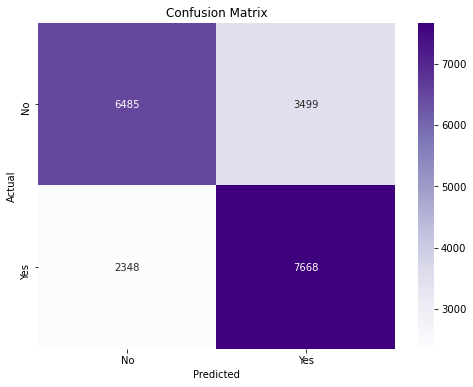

In [9]:
# Created the confusion matrix for visualization
cm1 = confusion_matrix(y_val, y_pred1, labels=logreg_pipeline.named_steps['model'].classes_)

plt.figure(figsize=(8, 6))
sns.heatmap(cm1, annot=True, fmt='d', cmap='Purples')

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

plt.xticks(ticks=[0.5, 1.5], labels=['No', 'Yes'])
plt.yticks(ticks=[0.5, 1.5], labels=['No', 'Yes'])

plt.show()

##### FINDINGS: Validation Set
__TP:__ The model correctly predicted __7,668__ individuals who would seek treatment for a mental illness.

__TN:__ The model correctly predicted __6,485__ individuals who would not seek treatment for a mental illness.

__FP:__ The model incorrectly predicted __3,499__ individuals as seeking treatment on their own when they will not.

__FN:__ The model incorrectly predicted __2,348__ individuals as not seeking treatment on their own when they will.

In [10]:
# Used Get Feature Name Out to get a list and total number of the columns created by OneHotEncoder
ohe_feature_names = logreg_pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out()

total_new_columns = len(ohe_feature_names)

print("\033[1mThe list of new columns from OHE is:\033[0m\n", ohe_feature_names)
print()
print("\033[1mThe total number of new columns is:\033[0m ", total_new_columns)

The list of new columns from OHE is:
 ['Gender_Female' 'Gender_Male' 'Family_History_No' 'Family_History_Yes'
 'Mental_Health_Interview_Maybe' 'Mental_Health_Interview_No'
 'Mental_Health_Interview_Yes' 'Care_Options_No' 'Care_Options_Not sure'
 'Care_Options_Yes' 'Self_Employed_No' 'Self_Employed_Yes'
 'Coping_Struggles_No' 'Coping_Struggles_Yes' 'Growing_Stress_Maybe'
 'Growing_Stress_No' 'Growing_Stress_Yes']

The total number of new columns is:  17


#### Tested on the Holdout set:

In [11]:
# Predictions & Evaluation on the holdout set
y_holdout_pred1 = logreg_pipeline.predict(X_holdout)

accuracy_holdout1 = accuracy_score(y_holdout, y_holdout_pred1)
classification_report_holdout1 = classification_report(y_holdout, y_holdout_pred1)

# Cross-validated
cv_scores_holdout1 = cross_val_score(logreg_pipeline, X, y, cv=10, scoring='accuracy')

print("\033[1mThe Accuracy score on the holdout set is:\033[0m ", accuracy_holdout1)
print("\033[1mClassification Report:\033[0m\n", classification_report_holdout1)
print("\033[1mCross-validation precision scores:\033[0m\n", cv_scores_holdout1)

The Accuracy score on the holdout set is:  0.70265
Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.64      0.69     10078
           1       0.68      0.76      0.72      9922

    accuracy                           0.70     20000
   macro avg       0.71      0.70      0.70     20000
weighted avg       0.71      0.70      0.70     20000

Cross-validation precision scores:
 [0.7076 0.71   0.7099 0.7119 0.7107 0.7128 0.6963 0.7143 0.698  0.7004]


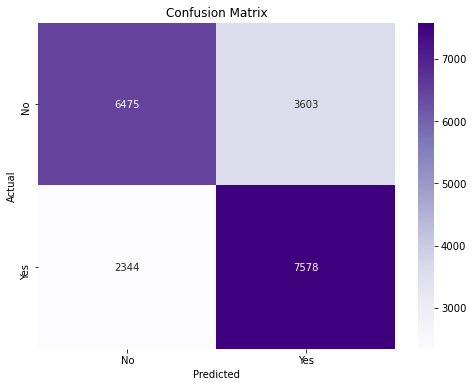

In [12]:
# Created the confusion matrix for visualization
cm_holdout1 = confusion_matrix(y_holdout, y_holdout_pred1, labels=logreg_pipeline.named_steps['model'].classes_)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_holdout1, annot=True, fmt='d', cmap='Purples')

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

plt.xticks(ticks=[0.5, 1.5], labels=['No', 'Yes'])
plt.yticks(ticks=[0.5, 1.5], labels=['No', 'Yes'])

plt.show()

##### FINDINGS Holdout Set:
Overall, the model's performance is similar to what was observed on the validation set (0.70765(__71%__) Validation and 0.70265(__70%__) Holdout), indicating that the model is generalizing well to unseen data. The TP, TN, FP, FN are all close to eachother as well.

__TP:__ Validation Set: __7,668__ -------- Holdout Set: __7,578__ 

__TN:__ Validation Set: __6,485__ -------- Holdout Set: __6,475__

__FP:__ Validation Set: __3,499__ -------- Holdout Set: __3,603__

__FN:__ Validation Set: __2,348__ -------- Holdout Set: __2,344__

## 4B. Model 2:  Random Forest Classifier

In [13]:
# Defined Random Forest Classifier as my 2nd model
RandForest = RandomForestClassifier(random_state=42)

# Added RandForest to empty model slot on pipeline
RF_pipeline = pipeline.set_params(model=RandForest)

RF_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Gender', 'Family_History',
                                                   'Mental_Health_Interview',
                                                   'Care_Options',
                                                   'Self_Employed',
                                                   'Coping_Struggles',
                                                   'Growing_Stress'])])),
                ('model', RandomForestClassifier(random_state=42))])

In [14]:
# Trained the model
RF_pipeline.fit(X_train, y_train)

# Predictions & Evaluation
y_pred2 = RF_pipeline.predict(X_val)
accuracy2 = accuracy_score(y_val, y_pred2)
classification_report2 = classification_report(y_val, y_pred2)

# Cross-validated
cv_scores2 = cross_val_score(RF_pipeline, X_train_val, y_train_val, cv=10, scoring='accuracy')

print("\033[1mThe Accuracy score on the validation set is:\033[0m ", accuracy2)
print("\033[1mClassification Report:\033[0m\n", classification_report2)
print("\033[1mCross-validation accuracy scores:\033[0m\n", cv_scores2)

The Accuracy score on the validation set is:  0.7268
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.63      0.70      9984
           1       0.69      0.83      0.75     10016

    accuracy                           0.73     20000
   macro avg       0.74      0.73      0.72     20000
weighted avg       0.74      0.73      0.72     20000

Cross-validation accuracy scores:
 [0.726625 0.72625  0.720375 0.721875 0.7305   0.721875 0.72325  0.72675
 0.73475  0.71775 ]


##### FINDINGS:  Validation Set
Keeping in mind that Yes = 1 and No = 0.  
The __Accuracy Score__ of __73%__(72.68%) means that out of every 100 samples, the model correctly predicted 73 of them.  

The __Precision__ score indicates that the model correctly predicted when a person would not seek treatment 78% of the time and correctly predicted when a person would seek treatment 69% of the time. 

The __Recall__ score indicates that the model correctly caught all the cases it needed to 63% of the time for those unlikely to seek treatment and 83% of the time for those likely to seek treatment.

The __F1__ score is a balanced view of the Precision and Recall Scores. In this case, the model is slightly better at predicting those who would seek treatment (Yes = 75%) than those who would not (No = 70%)  

The __Cross-Validation__ scores show how the models Accuracy score varied on different subsets of the training data. In this case, the scores ranged from 71.7% to 73.4% which means my model is fairly stable when makeing predictions.

So far the Random Forest Model is doing better than the Logisitc regression model in the sense of overall accuracy and the ability to correctly predict the No values.

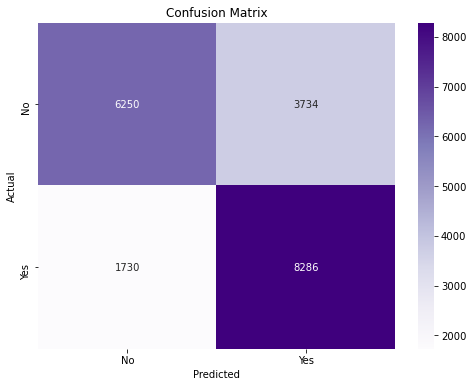

In [15]:
# Created the confusion matrix for visualization
cm2 = confusion_matrix(y_val, y_pred2, labels=RF_pipeline.named_steps['model'].classes_)

plt.figure(figsize=(8, 6))
sns.heatmap(cm2, annot=True, fmt='d', cmap='Purples')

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

plt.xticks(ticks=[0.5, 1.5], labels=['No', 'Yes'])
plt.yticks(ticks=[0.5, 1.5], labels=['No', 'Yes'])

plt.show()

##### FINDINGS: Validation Set(s)
__TP:__ The model correctly predicted __8,286__ individuals who would seek treatment for a mental illness.

__TN:__ The model correctly predicted __6,250__ individuals who would not seek treatment for a mental illness.

__FP:__ The model incorrectly predicted __3,734__ individuals as seeking treatment on their own when they will not.

__FN:__ The model incorrectly predicted __1,730__ individuals as not seeking treatment on their own when they will.

While Random Forest did increase the number of True Positives (7,668 LR --> 8,286 RF),  
it also increased the number of False Positives (3,499 LR --> 3,734 RF). 

And while it did decrease the number of False Negatives (2,348 LR --> 1,730 RF),  
it also decreased the number of True Negatives (6,485 LR --> 6,250 RF). 

I'm hoping that by using __Hyperparameter Tuning__ I'll be able to decrease my False Positives and increase my overall Accuracy Score.


#### GridSearchCV:
Used GridSearchCV to find the best hyperparameters and model.  Then applied that model to the pipeline and retested against the validation and holdout sets.

In [16]:
# Set up the parameter grid for hyperparameter tuning
RF_param_grid = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [None, 10, 20],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
}

# Set up GridSearchCV
grid_search_RF = GridSearchCV(RF_pipeline, RF_param_grid, cv=5, scoring='accuracy')

# Fit GridSearchCV to the train_val set to find the best parameters
grid_search_RF.fit(X_train_val, y_train_val)

# Best hyperparameters and the corresponding best model
best_RF_params = grid_search_RF.best_params_
best_RF_model = grid_search_RF.best_estimator_
best_RF_score = grid_search_RF.best_score_

print("\033[1mThe Best Parameters are:\033[0m\n", best_RF_params)
print()
print("\033[1mThe Best Model is:\033[0m\n", best_RF_model)
print()
print("\033[1mThe Best Accuracy Score is: \033[0m", best_RF_score)

The Best Parameters are:
 {'model__max_depth': None, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 200}

The Best Model is:
 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Gender', 'Family_History',
                                                   'Mental_Health_Interview',
                                                   'Care_Options',
                                                   'Self_Employed',
                                                   'Coping_Struggles',
                                                   'Growing_Stress'])])),
                ('model',
                 RandomForestClassifier(n_estimators=200, random_state=42))])

The Best Accuracy 

In [17]:
# Printed the Best Models Parameters
print(best_RF_model.named_steps['model'].get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 200, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


#### Testing on the Validation and Holdout Sets w. Best Model

In [18]:
# Evaluated the accuracy score on the validation set
val_accuracy = best_RF_model.score(X_val, y_val)

# Evaluated the accuracy score on the holdout set
holdout_accuracy = best_RF_model.score(X_holdout, y_holdout)

print("\033[1mThe Validation Set Accuracy Score is:\033[0m ", val_accuracy)
print("\033[1mThe Holdout Set Accuracy Score is:\033[0m ", holdout_accuracy)

The Validation Set Accuracy Score is:  0.72845
The Holdout Set Accuracy Score is:  0.71915


In [19]:
# Created the confusion matrix for visualization

# Got predictions on validation set
y_valcm_pred = best_RF_model.predict(X_val)

# Got predictions on holdout set
y_holdoutcm_pred = best_RF_model.predict(X_holdout)

# Generated the confusion matrices
conf_matrix_val = confusion_matrix(y_val, y_valcm_pred)
conf_matrix_holdout = confusion_matrix(y_holdout, y_holdoutcm_pred)

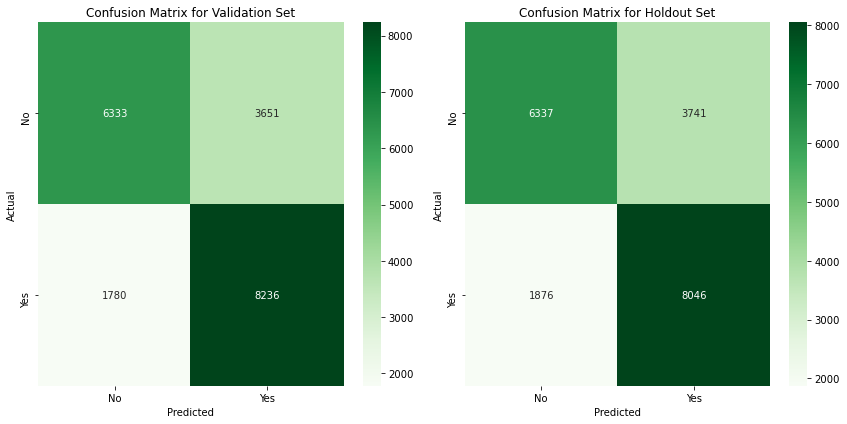

In [20]:
plt.figure(figsize=(12, 6))

# Plotted the confusion matrix for the validation set
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
sns.heatmap(conf_matrix_val, annot=True, fmt="d", cmap="Greens")

plt.title('Confusion Matrix for Validation Set')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.xticks(ticks=[0.5, 1.5], labels=['No', 'Yes'])
plt.yticks(ticks=[0.5, 1.5], labels=['No', 'Yes'])


# Plotted the confusion matrix for the holdout set
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
sns.heatmap(conf_matrix_holdout, annot=True, fmt="d", cmap="Greens")

plt.title('Confusion Matrix for Holdout Set')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.xticks(ticks=[0.5, 1.5], labels=['No', 'Yes'])
plt.yticks(ticks=[0.5, 1.5], labels=['No', 'Yes'])


plt.tight_layout()

plt.show()

##### FINDINGS:
Overall, with the hyperparameter tuning, the model's performance is similar to what was observed on the original validation set but does show a slight increase in the Accuracy score (__72.68%__ Original Validation and __72.85%__ HyperTuned Validation).  The Holdout set's Accuracy score read __71.92%__ indicating that the model is still generalizing well to unseen data.  
The TP, TN, FP, FN show some variation between the original validation set and the HyperTuned Validation set.

__TP:__ Original Validation Set: __8,286__ ------ Hyper Validation Set: __8,236__ ------ Hyper Holdout Set: __8,046__ 

__TN:__ Original Validation Set: __6,250__ ------ Hyper Validation Set: __6,333__ ------ Hyper Holdout Set: __6,337__

__FP:__ Original Validation Set: __3,734__ ------ Hyper Validation Set: __3,651__ ------ Hyper Holdout Set: __3,741__

__FN:__ Original Validation Set: __1,730__ ------ Hyper Validation Set: __1,780__ ------ Hyper Holdout Set: __1,876__

## 4C. Model 3:  XGB Classifier

In [21]:
# Defined XGBClassifier as my 3rd model
XGBClass = XGBClassifier(eval_metric='logloss', random_state=42)

# Added XGBClass to empty model slot on pipeline
XGBClass_pipeline = pipeline.set_params(model=XGBClass)

XGBClass_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Gender', 'Family_History',
                                                   'Mental_Health_Interview',
                                                   'Care_Options',
                                                   'Self_Employed',
                                                   'Coping_Struggles',
                                                   'Growing_Stress'])])),
                ('model',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_b...
                               gamma=None, gpu_id=None, importance_type='gain',
                               interaction_constraints=None, learning_rate=None,
                               max_delta_step=None, max_depth=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               random_state=42, reg_alpha=None, reg_lambda=None,
                               scale_pos_weight=None, subsample=None,
                               tree_method=None, validate_parameters=None,
                               verbosity=None))])

In [22]:
# Trained the model
XGBClass_pipeline.fit(X_train, y_train)

# Predictions & Evaluation
y_pred3 = XGBClass_pipeline.predict(X_val)
accuracy3 = accuracy_score(y_val, y_pred3)
classification_report3 = classification_report(y_val, y_pred3)

# Cross-validated
cv_scores3 = cross_val_score(XGBClass_pipeline, X_train_val, y_train_val, cv=10, scoring='accuracy')

print("\033[1mThe Accuracy score on the validation set is:\033[0m ", accuracy3)
print("\033[1mClassification Report:\033[0m\n", classification_report3)
print("\033[1mCross-validation accuracy scores:\033[0m\n", cv_scores3)

The Accuracy score on the validation set is:  0.72715
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.62      0.70      9984
           1       0.69      0.83      0.75     10016

    accuracy                           0.73     20000
   macro avg       0.74      0.73      0.72     20000
weighted avg       0.74      0.73      0.72     20000

Cross-validation accuracy scores:
 [0.7285   0.726875 0.720375 0.721875 0.7305   0.721875 0.72325  0.72675
 0.73475  0.7185  ]


##### FINDINGS:  Validation Set
Keeping in mind that Yes = 1 and No = 0.  
The __Accuracy Score__ of __73%__ (72.72%) means that out of every 100 samples, the model correctly predicted 73 of them. This is slightly better than Random Forest but not by much.  

The __Precision__ score indicates that the model correctly predicted when a person would not seek treatment 79% of the time and correctly predicted when a person would seek treatment 69% of the time. 

The __Recall__ score indicates that the model correctly caught all the cases it needed to 62% of the time for those unlikely to seek treatment and 83% of the time for those likely to seek treatment.

The __F1__ score is a balanced view of the Precision and Recall Scores. In this case, the model is slightly better at predicting those who would seek treatment (Yes = 75%) than those who would not (No = 70%)  

The __Cross-Validation__ scores show how the models Accuracy score varied on different subsets of the training data. In this case, the scores ranged from 71.9% to 73.5% which means my model is still stable when makeing predictions.

So far the XGB Classifier accuracy score (72.72%) falls between the Orginal Random Forest model (72.68%) and the HyperTuned Random Forest Model (72.85%) in the sense of overall accuracy and the ability to correctly predict the No values.

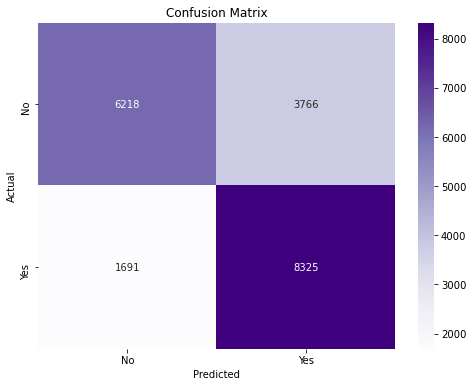

In [23]:
# Created the confusion matrix for visualization
cm3 = confusion_matrix(y_val, y_pred3, labels=XGBClass_pipeline.named_steps['model'].classes_)

plt.figure(figsize=(8, 6))
sns.heatmap(cm3, annot=True, fmt='d', cmap='Purples')

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

plt.xticks(ticks=[0.5, 1.5], labels=['No', 'Yes'])
plt.yticks(ticks=[0.5, 1.5], labels=['No', 'Yes'])

plt.show()

##### FINDINGS: Validation Set
__TP:__ The model correctly predicted __8,325__ individuals who would seek treatment for a mental illness.

__TN:__ The model correctly predicted __6,218__ individuals who would not seek treatment for a mental illness.

__FP:__ The model incorrectly predicted __3,766__ individuals as seeking treatment on their own when they will not.

__FN:__ The model incorrectly predicted __1,691__ individuals as not seeking treatment on their own when they will.

While XGBoost did increase the number of True Positives (7,668 LR --> 8,286 RF --> 8,325 XGB),  
it also again increased the number of False Positives (3,499 LR --> 3,734 RF --> 3,766 XGB).

And while it again did decrease the number of False Negatives (2,348 LR --> 1,730 RF --> 1691 XGB),  
it also decreased the number of True Negatives (6,485 LR --> 6,250 RF --> 6,218 XGB).  

I'm hoping that by using __Hyperparameter Tuning__ on XGBoost, I'll be able to see a more distinct decrease in my False Positives and an increase in my overall Accuracy Score.

#### GridSearchCV:
Used GridSearchCV again to find the best hyperparameters and model.  Then applied that model to the pipeline and retested against the validation and holdout sets.

In [24]:
# Defined XGB Classifier with the new parameters
XGBClass_param_grid = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [3, 6, 10],
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__subsample': [0.6, 0.8, 1.0],
    'model__min_child_weight': [1, 3, 5],
}

# Set up GridSearchCV
grid_search_XGBClass = GridSearchCV(XGBClass_pipeline, XGBClass_param_grid, cv=5, scoring='accuracy')

# Fit GridSearchCV to the train_val set to find the best parameters
grid_search_XGBClass.fit(X_train_val, y_train_val)

# Best hyperparameters and the corresponding best model
best_XGBClass_params = grid_search_XGBClass.best_params_
best_XGBClass_model = grid_search_XGBClass.best_estimator_
best_XGBClass_score = grid_search_XGBClass.best_score_

print("\033[1mThe Best Parameters are:\033[0m\n", best_XGBClass_params)
print()
print("\033[1mThe Best Model is:\033[0m\n", best_XGBClass_model)
print()
print("\033[1mThe Best Accuracy Score is: \033[0m", best_XGBClass_score)

The Best Parameters are:
 {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__min_child_weight': 5, 'model__n_estimators': 200, 'model__subsample': 0.8}

The Best Model is:
 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Gender', 'Family_History',
                                                   'Mental_Health_Interview',
                                                   'Care_Options',
                                                   'Self_Employed',
                                                   'Coping_Struggles',
                                                   'Growing_Stress'])])),
                ('model',
                 XGBClassifier(base_score=0.5, booster='gbtree',
            

#### Testing on the Validation and Holdout Sets w. Best Model

In [25]:
# Evaluate accuracy on the validation set
val_accuracy = best_XGBClass_model.score(X_val, y_val)

# Evaluate accuracy on the holdout set
holdout_accuracy = best_XGBClass_model.score(X_holdout, y_holdout)

print("\033[1mThe Validation Set Accuracy Score is:\033[0m ", val_accuracy)
print("\033[1mThe Holdout Set Accuracy Score is:\033[0m ", holdout_accuracy)

The Validation Set Accuracy Score is:  0.7299
The Holdout Set Accuracy Score is:  0.71885


In [26]:
# Created the confusion matrix for visualization

# Got predictions on validation set
y_valcm2_pred = best_XGBClass_model.predict(X_val)

# Got predictions on holdout set
y_holdoutcm2_pred = best_XGBClass_model.predict(X_holdout)

# Generated the confusion matrices
conf_matrix2_val = confusion_matrix(y_val, y_valcm2_pred)
conf_matrix2_holdout = confusion_matrix(y_holdout, y_holdoutcm2_pred)

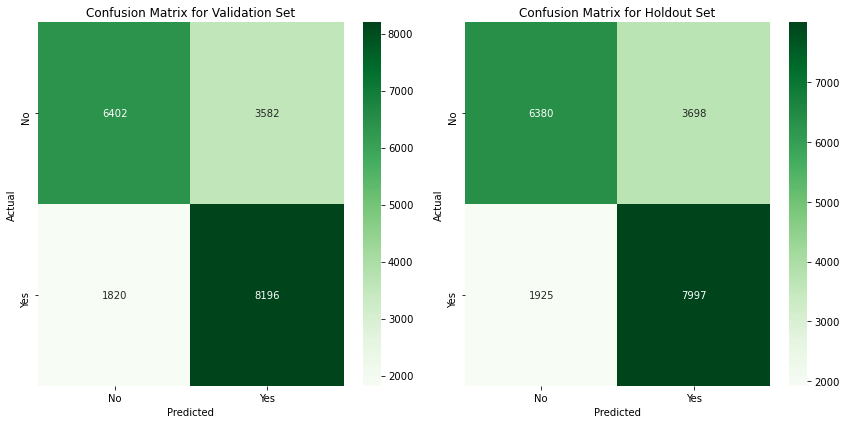

In [27]:
plt.figure(figsize=(12, 6))

# Plotted the confusion matrix for the validation set
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
sns.heatmap(conf_matrix2_val, annot=True, fmt="d", cmap="Greens")

plt.title('Confusion Matrix for Validation Set')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.xticks(ticks=[0.5, 1.5], labels=['No', 'Yes'])
plt.yticks(ticks=[0.5, 1.5], labels=['No', 'Yes'])


# Plotted the confusion matrix for the holdout set
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
sns.heatmap(conf_matrix2_holdout, annot=True, fmt="d", cmap="Greens")

plt.title('Confusion Matrix for Holdout Set')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.xticks(ticks=[0.5, 1.5], labels=['No', 'Yes'])
plt.yticks(ticks=[0.5, 1.5], labels=['No', 'Yes'])

plt.tight_layout()

plt.show()

##### FINDINGS:
Overall, with the hyperparameter tuning, the model's performance is similar to what was observed on the original validation set but does again show a slight increase in the Accuracy score (__72.72%__ Original Validation and __72.99%__ HyperTuned Validation).  The Holdout set's Accuracy score is __71.89%__ indicating that the model is still generalizing well to unseen data.  
The TP, TN, FP, FN show some variation between the original validation set and the HyperTuned Validation set.

__TP:__ Original Validation Set: __8,325__ ------ Hyper Validation Set: __8,196__ ------ Hyper Holdout Set: __7,997__ 

__TN:__ Original Validation Set: __6,218__ ------ Hyper Validation Set: __6,402__ ------ Hyper Holdout Set: __6,380__

__FP:__ Original Validation Set: __3,766__ ------ Hyper Validation Set: __3,582__ ------ Hyper Holdout Set: __3,698__

__FN:__ Original Validation Set: __1,691__ ------ Hyper Validation Set: __1,820__ ------ Hyper Holdout Set: __1,925__